---
## This notebook will contain the functions which will be useful for Triplet Loss Learning

---

In [1]:
import pandas as pd
import numpy as np
import torch
import random
import torch.nn as nn
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import AutoTokenizer, AutoModel

C:\Users\solom\miniconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
torch.cuda.is_available()

True

In [4]:
# Cast to GPU if not it will be processed with CPU
device = torch.device('cuda')

---
### Useful Functions

---

In [5]:
def cos_sim(anchor_array, comparison_array):
    """
    Does consine similarity comparison via matrix operations.
    
    Faster than pair by pair comparison using sklearn's cosine_similarity function as this calculates anchor to multiple comparisons via single matrix operation.
    """
    
    return np.dot(comparison_array, anchor_array)/(norm(comparison_array, axis=1)*norm(anchor_array))

In [6]:
def mean_pooling(model_outputs, attention_mask):
    """
    See hugging face documentation.
    """
    
    token_embeddings = model_outputs[0] # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [7]:
def offline_hard_neg_mining(checkpoint_input_df, model, tokenizer):
    updated_training_dataset = pd.DataFrame(columns=checkpoint_input_df.columns)
    
    encoded_df = checkpoint_input_df.copy()
    encoded_df.reset_index(inplace=True)
    
    with torch.no_grad():
        start_counter = 0
        
        for i in range(encoded_df.shape[0]):
            if ((i%200)==0) & (i!=0):
                if (i%50000)==0:
                    print ("Embedding and comparing completed till " + str(i))
                    
                batch_df = encoded_df.iloc[start_counter:i, :]
                
                anchor_batch = batch_df['anchor'].tolist()
                pos_batch = batch_df['positive'].tolist()
                neg_batch = batch_df['negative'].tolist()
                
                encoded_anchor = tokenizer(anchor_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_anchor_batch_output = model(**encoded_anchor)
                batch_anchor_sentence_embeddings = mean_pooling(model_anchor_batch_output, encoded_anchor['attention_mask'])
                
                encoded_pos = tokenizer(pos_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_pos_batch_output = model(**encoded_pos)
                batch_pos_sentence_embeddings = mean_pooling(model_pos_batch_output, encoded_pos['attention_mask'])
                
                encoded_neg = tokenizer(neg_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_neg_batch_output = model(**encoded_neg)
                batch_neg_sentence_embeddings = mean_pooling(model_neg_batch_output, encoded_anchor['attention_mask'])
                
                batch_df['anchor_embeddings'] = batch_anchor_sentence_embeddings.tolist()
                batch_df['pos_embeddings'] = batch_pos_sentence_embeddings.tolist()
                batch_df['neg_embeddings'] = batch_neg_sentence_embeddings.tolist()
                
                for index in batch_df.index:
                    anchor = batch_df.loc[index, 'anchor_embeddings']
                    positive = batch_df.loc[index, 'pos_embeddings']
                    negative = batch_df.loc[index, 'neg_embeddings']
                    
                    distance_pos = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(positive).reshape(1,-1))[0][0]
                    distance_neg = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(negative).reshape(1,-1))[0][0]
                    
                    # Hard Negative: d(A,P) > d(A,N)
                    # Distance of the positive should be smaller/closer to the anchor than the negative
                    if distance_pos > distance_neg:
                        updated_training_dataset = updated_training_dataset.append(batch_df.loc[index, ['anchor', 'positive', 'negative']])
                
                start_counter = i
                
            if i==(encoded_df.shape[0]-1):
                print ("Embedding and comparing completed till " + str(i))
                batch_df = encoded_df.iloc[start_counter:, :]

                anchor_batch = batch_df['anchor'].tolist()
                pos_batch = batch_df['positive'].tolist()
                neg_batch = batch_df['negative'].tolist()

                encoded_anchor = tokenizer(anchor_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_anchor_batch_output = model(**encoded_anchor)
                batch_anchor_sentence_embeddings = mean_pooling(model_anchor_batch_output, encoded_anchor['attention_mask'])

                encoded_pos = tokenizer(pos_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_pos_batch_output = model(**encoded_pos)
                batch_pos_sentence_embeddings = mean_pooling(model_pos_batch_output, encoded_pos['attention_mask'])

                encoded_neg = tokenizer(neg_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_neg_batch_output = model(**encoded_neg)
                batch_neg_sentence_embeddings = mean_pooling(model_neg_batch_output, encoded_anchor['attention_mask'])

                batch_df['anchor_embeddings'] = batch_anchor_sentence_embeddings.tolist()
                batch_df['pos_embeddings'] = batch_pos_sentence_embeddings.tolist()
                batch_df['neg_embeddings'] = batch_neg_sentence_embeddings.tolist()

                for index in batch_df.index:
                    anchor = batch_df.loc[index, 'anchor_embeddings']
                    positive = batch_df.loc[index, 'pos_embeddings']
                    negative = batch_df.loc[index, 'neg_embeddings']

                    distance_pos = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(positive).reshape(1,-1))[0][0]
                    distance_neg = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(negative).reshape(1,-1))[0][0]

                    # Hard Negative: d(A,P) > d(A,N)
                    # Distance of the positive should be smaller/closer to the anchor than the negative
                    if distance_pos > distance_neg:
                        updated_training_dataset = updated_training_dataset.append(batch_df.loc[index, ['anchor', 'positive', 'negative']])
                        
    return updated_training_dataset

In [8]:
def offline_semi_hard_neg_mining(checkpoint_input_df, model, tokenizer, margin):
    updated_training_dataset = pd.DataFrame(columns=checkpoint_input_df.columns)
    
    encoded_df = checkpoint_input_df.copy()
    encoded_df.reset_index(inplace=True)
    
    with torch.no_grad():
        start_counter = 0
        
        for i in range(encoded_df.shape[0]):
            if ((i%200)==0) & (i!=0):
                if (i%50000)==0:
                    print ("Embedding and comparing completed till " + str(i))
                    
                batch_df = encoded_df.iloc[start_counter:i, :]
                
                anchor_batch = batch_df['anchor'].tolist()
                pos_batch = batch_df['positive'].tolist()
                neg_batch = batch_df['negative'].tolist()
                
                encoded_anchor = tokenizer(anchor_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_anchor_batch_output = model(**encoded_anchor)
                batch_anchor_sentence_embeddings = mean_pooling(model_anchor_batch_output, encoded_anchor['attention_mask'])
                
                encoded_pos = tokenizer(pos_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_pos_batch_output = model(**encoded_pos)
                batch_pos_sentence_embeddings = mean_pooling(model_pos_batch_output, encoded_pos['attention_mask'])
                
                encoded_neg = tokenizer(neg_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_neg_batch_output = model(**encoded_neg)
                batch_neg_sentence_embeddings = mean_pooling(model_neg_batch_output, encoded_anchor['attention_mask'])
                
                batch_df['anchor_embeddings'] = batch_anchor_sentence_embeddings.tolist()
                batch_df['pos_embeddings'] = batch_pos_sentence_embeddings.tolist()
                batch_df['neg_embeddings'] = batch_neg_sentence_embeddings.tolist()
                
                for index in batch_df.index:
                    anchor = batch_df.loc[index, 'anchor_embeddings']
                    positive = batch_df.loc[index, 'pos_embeddings']
                    negative = batch_df.loc[index, 'neg_embeddings']
                    
                    distance_pos = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(positive).reshape(1,-1))[0][0]
                    distance_neg = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(negative).reshape(1,-1))[0][0]
                    
                    # Semi Hard Negative: d(A,P) < d(A,N) < d(A,P)+margin
                    # Distance of positive is closer than negative to anchor but negtive not yet of margin away from positive distance
                    if (distance_pos<distance_neg) & (distance_neg<(distance_pos+margin)):
                        updated_training_dataset = updated_training_dataset.append(batch_df.loc[index, ['anchor', 'positive', 'negative']])
                
                start_counter = i
                
            if i==(encoded_df.shape[0]-1):
                print ("Embedding and comparing completed till " + str(i))
                batch_df = encoded_df.iloc[start_counter:, :]

                anchor_batch = batch_df['anchor'].tolist()
                pos_batch = batch_df['positive'].tolist()
                neg_batch = batch_df['negative'].tolist()

                encoded_anchor = tokenizer(anchor_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_anchor_batch_output = model(**encoded_anchor)
                batch_anchor_sentence_embeddings = mean_pooling(model_anchor_batch_output, encoded_anchor['attention_mask'])

                encoded_pos = tokenizer(pos_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_pos_batch_output = model(**encoded_pos)
                batch_pos_sentence_embeddings = mean_pooling(model_pos_batch_output, encoded_pos['attention_mask'])

                encoded_neg = tokenizer(neg_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_neg_batch_output = model(**encoded_neg)
                batch_neg_sentence_embeddings = mean_pooling(model_neg_batch_output, encoded_anchor['attention_mask'])

                batch_df['anchor_embeddings'] = batch_anchor_sentence_embeddings.tolist()
                batch_df['pos_embeddings'] = batch_pos_sentence_embeddings.tolist()
                batch_df['neg_embeddings'] = batch_neg_sentence_embeddings.tolist()

                for index in batch_df.index:
                    anchor = batch_df.loc[index, 'anchor_embeddings']
                    positive = batch_df.loc[index, 'pos_embeddings']
                    negative = batch_df.loc[index, 'neg_embeddings']

                    distance_pos = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(positive).reshape(1,-1))[0][0]
                    distance_neg = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(negative).reshape(1,-1))[0][0]

                    # Semi Hard Negative: d(A,P) < d(A,N) < d(A,P)+margin
                    # Distance of positive is closer than negative to anchor but negtive not yet of margin away from positive distance
                    if (distance_pos<distance_neg) & (distance_neg<(distance_pos+margin)):
                        updated_training_dataset = updated_training_dataset.append(batch_df.loc[index, ['anchor', 'positive', 'negative']])
                        
    return updated_training_dataset

In [9]:
def offline_hardest_neg_mining(checkpoint_input_df, model, tokenizer, size):
    updated_training_dataset = pd.DataFrame(columns=checkpoint_input_df.columns+['score'])
    
    encoded_df = checkpoint_input_df.copy()
    encoded_df.reset_index(inplace=True)
    
    encoded_df['score'] = None
    
    with torch.no_grad():
        start_counter = 0
        
        for i in range(encoded_df.shape[0]):
            if ((i%200)==0) & (i!=0):
                if (i%50000)==0:
                    print ("Embedding and comparing completed till " + str(i))
                    
                batch_df = encoded_df.iloc[start_counter:i, :]
                
                anchor_batch = batch_df['anchor'].tolist()
                pos_batch = batch_df['positive'].tolist()
                neg_batch = batch_df['negative'].tolist()
                
                encoded_anchor = tokenizer(anchor_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_anchor_batch_output = model(**encoded_anchor)
                batch_anchor_sentence_embeddings = mean_pooling(model_anchor_batch_output, encoded_anchor['attention_mask'])
                
                encoded_pos = tokenizer(pos_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_pos_batch_output = model(**encoded_pos)
                batch_pos_sentence_embeddings = mean_pooling(model_pos_batch_output, encoded_pos['attention_mask'])
                
                encoded_neg = tokenizer(neg_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_neg_batch_output = model(**encoded_neg)
                batch_neg_sentence_embeddings = mean_pooling(model_neg_batch_output, encoded_anchor['attention_mask'])
                
                batch_df['anchor_embeddings'] = batch_anchor_sentence_embeddings.tolist()
                batch_df['pos_embeddings'] = batch_pos_sentence_embeddings.tolist()
                batch_df['neg_embeddings'] = batch_neg_sentence_embeddings.tolist()
                
                for index in batch_df.index:
                    anchor = batch_df.loc[index, 'anchor_embeddings']
                    positive = batch_df.loc[index, 'pos_embeddings']
                    negative = batch_df.loc[index, 'neg_embeddings']
                    
                    distance_pos = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(positive).reshape(1,-1))[0][0]
                    distance_neg = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(negative).reshape(1,-1))[0][0]
                    
                    batch_df.loc[index, ['score']] = distance_neg - distance_pos
                    
                    # Hard Negative: d(A,P) > d(A,N)
                    # Distance of the positive should be smaller/closer to the anchor than the negative
                    if distance_pos > distance_neg:
                        updated_training_dataset = updated_training_dataset.append(batch_df.loc[index, ['anchor', 'positive', 'negative', 'score']])
                
                start_counter = i
                
            if i==(encoded_df.shape[0]-1):
                print ("Embedding and comparing completed till " + str(i))
                batch_df = encoded_df.iloc[start_counter:, :]

                anchor_batch = batch_df['anchor'].tolist()
                pos_batch = batch_df['positive'].tolist()
                neg_batch = batch_df['negative'].tolist()

                encoded_anchor = tokenizer(anchor_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_anchor_batch_output = model(**encoded_anchor)
                batch_anchor_sentence_embeddings = mean_pooling(model_anchor_batch_output, encoded_anchor['attention_mask'])

                encoded_pos = tokenizer(pos_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_pos_batch_output = model(**encoded_pos)
                batch_pos_sentence_embeddings = mean_pooling(model_pos_batch_output, encoded_pos['attention_mask'])

                encoded_neg = tokenizer(neg_batch, max_length=150, padding=True, truncation=True, return_tensors='pt').to(device)
                model_neg_batch_output = model(**encoded_neg)
                batch_neg_sentence_embeddings = mean_pooling(model_neg_batch_output, encoded_anchor['attention_mask'])

                batch_df['anchor_embeddings'] = batch_anchor_sentence_embeddings.tolist()
                batch_df['pos_embeddings'] = batch_pos_sentence_embeddings.tolist()
                batch_df['neg_embeddings'] = batch_neg_sentence_embeddings.tolist()

                for index in batch_df.index:
                    anchor = batch_df.loc[index, 'anchor_embeddings']
                    positive = batch_df.loc[index, 'pos_embeddings']
                    negative = batch_df.loc[index, 'neg_embeddings']

                    distance_pos = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(positive).reshape(1,-1))[0][0]
                    distance_neg = cosine_similarity(np.array(anchor).reshape(1,-1), np.array(negative).reshape(1,-1))[0][0]
                    
                    batch_df.loc[index, ['score']] = distance_neg - distance_pos
                    
                    # Hard Negative: d(A,P) > d(A,N)
                    # Distance of the positive should be smaller/closer to the anchor than the negative
                    if distance_pos > distance_neg:
                        updated_training_dataset = updated_training_dataset.append(batch_df.loc[index, ['anchor', 'positive', 'negative', 'score']])
    
    updated_training_dataset = updated_training_dataset.sort_values('score', ascending=False)
    updated_training_dataset = updated_training_dataset[['anchor', 'positive', 'negative']]
    
    return updated_training_dataset.iloc[:size, :]

---
### Sample Fine-tuning

Will not be splitting the toy dataset as it is just meant to show the process

---

In [10]:
df = pd.read_csv('../0. Sample Datasets/quora_question_triplet.csv')

In [11]:
pd.set_option('display.max_column', None) 
df.head()

,anchor,positive,negative
0,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",How can I be a good geologist?
1,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",How do I read and find my YouTube comments?
2,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",What can make Physics easy to learn?
3,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",What was your first sexual experience like?
4,How can I be a good geologist?,What should I do to be a great geologist?,Astrology: I am a Capricorn Sun Cap moon and c...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   anchor    21 non-null     object
 1   positive  21 non-null     object
 2   negative  21 non-null     object
dtypes: object(3)
memory usage: 632.0+ bytes


#### Loading Model and Tokenizer

In [13]:
tokenizer = AutoTokenizer.from_pretrained("D:\\DSAI\\\Pre-Trained Models\\all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("D:\\DSAI\\\Pre-Trained Models\\all-MiniLM-L6-v2")

#### Splitting data for validation

In [14]:
X_train, X_val = train_test_split(df, test_size=0.1, random_state=7)

In [15]:
X_val_anchor = tokenizer(X_val['anchor'].tolist(), max_length=150, padding=True, truncation=True, return_tensors='pt')
X_val_positive = tokenizer(X_val['positive'].tolist(), max_length=150, padding=True, truncation=True, return_tensors='pt')
X_val_negative = tokenizer(X_val['negative'].tolist(), max_length=150, padding=True, truncation=True, return_tensors='pt')

In [21]:
val_anchor_seq = torch.tensor(X_val_anchor['input_ids'])
val_anchor_mask = torch.tensor(X_val_anchor['attention_mask'])

val_positive_seq = torch.tensor(X_val_positive['input_ids'])
val_positive_mask = torch.tensor(X_val_positive['attention_mask'])

val_negative_seq = torch.tensor(X_val_negative['input_ids'])
val_negative_mask = torch.tensor(X_val_negative['attention_mask'])

In [22]:
# Define batch size
batch_size = 8

# Wrap tensors
val_data = TensorDataset(val_anchor_seq, val_anchor_mask, val_positive_seq, val_positive_mask, val_negative_seq, val_negative_mask)

# Sampler for sampling the data during validation for training
val_sampler = SequentialSampler(val_data)

# Dataloader for val set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Training

In [18]:
model = model.to(device)

In [19]:
from torch.optim import AdamW

# Define optimiser
optimizer = AdamW(model.parameters(), lr=1e-5)

In [20]:
# Define loss function
loss_fn = nn.TripletMarginWithDistanceLoss(distance_function=nn.CosineSimilarity(), margin=1.0)

In [21]:
def train(train_dataloader):
    model.train()
    
    total_loss, total_accuracy = 0, 0
    
    # Empty list to save model predictions
    total_preds = []
    
    # Iterate over batches
    for step, batch in enumerate(train_dataloader):
        # Progress update for every 50 batches
        if step%50==0 and not step==0:
            print ('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))

        # Push batch to GPU
        batch = [r.to(device) for r in batch]
        anchor_id, anchor_mask, positive_id, positive_mask, negative_id, negative_mask = batch

        # Clear previously calculated gradients
        model.zero_grad()

        # Get model predictions for the current batch
        anchor_output = model(anchor_id, anchor_mask)
        positive_output = model(positive_id, positive_mask)
        negative_output = model(negative_id, negative_mask)
        
        """
        nn.CosineSimilarity measures similarity between 2 outputs, the more similar, the bigger the score.
        However for triplet loss, the positive cases are supposed to be closer and have a smaller score.
        To make things easier, we flipped the negative and positive positions
        i.e. loss(anchor, positive, negative) --> loss(anchor, negative, positive)
        """

        # Compute loss 
        loss = loss_fn(mean_pooling(anchor_output, anchor_mask), mean_pooling(negative_output, negative_mask), mean_pooling(positive_output, positive_mask))

        # Add on to the total loss
        total_loss = total_loss + loss.item()

        # Backward pass to calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()

    # Compute training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    return avg_loss

In [22]:
def evaluate():
    print ('\nEvaluating...')
    
    # Deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0
    
    # Empty list to save model predictions
    total_preds = []
    
    # Iterate over batches
    for step, batch in enumerate(val_dataloader):
        # Progress update for every 50 batches
        if step%50==0 and not step==0:
            print ('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))

        # Push batch to GPU
        batch = [t.to(device) for t in batch]
        anchor_id, anchor_mask, positive_id, positive_mask, negative_id, negative_mask = batch

        # Deactivate autograd()
        with torch.no_grad():

            # Get model predictions for the current batch
            anchor_output = model(anchor_id, anchor_mask)
            positive_output = model(positive_id, positive_mask)
            negative_output = model(negative_id, negative_mask)
            
            """
            nn.CosineSimilarity measures similarity between 2 outputs, the more similar, the bigger the score.
            However for triplet loss, the positive cases are supposed to be closer and have a smaller score.
            To make things easier, we flipped the negative and positive positions
            i.e. loss(anchor, positive, negative) --> loss(anchor, negative, positive)
            """

            # Compute loss 
            loss = loss_fn(mean_pooling(anchor_output, anchor_mask), mean_pooling(negative_output, negative_mask), mean_pooling(positive_output, positive_mask))

            total_loss = total_loss + loss.item()

    # Compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    return avg_loss

In [23]:
# No of training epochs
epochs = 30

# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# For each epoch
for epoch in range(epochs):
    print ('\nEpoch {:}/ {:}'.format(epoch+1, epochs))
    
    # Evaluate and curate dataset for training
    # For first 3 epochs use semi-hard negative mining, from 6th epoch onwards all hard negative mining
    if epoch<=2:
        print("Implementing Offline Semi-Hard Negative Mining")
        
        offline_triplet_selection = offline_semi_hard_neg_mining(X_train, model, tokenizer, margin=1.0)
        
        if offline_triplet_selection.shape[0]==0: # If the model is already good and unable to find negative examples, use entire train dataset
            offline_triplet_selection = X_train
    else:
        print("Implementing Offline Hard Negative Mining")
        
        offline_triplet_selection = offline_hard_neg_mining(X_train, model, tokenizer)
        
        if offline_triplet_selection.shape[0]==0: # If the model is already good and unable to find negative examples, use entire train dataset
            offline_triplet_selection = X_train
        
    print ("Size of selected dataset: ", str(offline_triplet_selection.shape[0]))
    
    # Tokenize selected triplets
    X_train_anchor = tokenizer(offline_triplet_selection['anchor'].tolist(), max_length=150, padding=True, truncation=True, return_tensors='pt')
    X_train_positive = tokenizer(offline_triplet_selection['positive'].tolist(), max_length=150, padding=True, truncation=True, return_tensors='pt')
    X_train_negative = tokenizer(offline_triplet_selection['negative'].tolist(), max_length=150, padding=True, truncation=True, return_tensors='pt')
    
    # Convert list to tensors
    train_anchor_seq = torch.tensor(X_train_anchor['input_ids'])
    train_anchor_mask = torch.tensor(X_train_anchor['attention_mask'])

    train_positive_seq = torch.tensor(X_train_positive['input_ids'])
    train_positive_mask = torch.tensor(X_train_positive['attention_mask'])

    train_negative_seq = torch.tensor(X_train_negative['input_ids'])
    train_negative_mask = torch.tensor(X_train_negative['attention_mask'])
    
    # Curate new tensor dataset
    # Wrap tensors
    train_data = TensorDataset(train_anchor_seq, train_anchor_mask, train_positive_seq, train_positive_mask, train_negative_seq, train_negative_mask)

    # Sampler for sampling the data during training
    train_sampler = RandomSampler(train_data)

    # Dataloader for train set
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    
    print ("Number of training batches: ", str(len(train_dataloader)))
    
    # Train model
    train_loss = train(train_dataloader=train_dataloader)
    
    # Evaluate model
    valid_loss = evaluate()
    
    # Save the best model
    if valid_loss<best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), 'saved_model_weights/pytorch_siamese_network.pt')
        
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print (f"\nTraining Loss: {train_loss:.8f}")
    print (f"Validation Loss: {valid_loss:.8f}")


Epoch 1/ 30
Implementing Offline Semi-Hard Negative Mining
Embedding and comparing completed till 17
Size of selected dataset:  1
Number of training batches:  1

Evaluating...

Training Loss: 1.59172165
Validation Loss: 0.13888678

Epoch 2/ 30
Implementing Offline Semi-Hard Negative Mining
Embedding and comparing completed till 17
Size of selected dataset:  1
Number of training batches:  1

Evaluating...

Training Loss: 1.43918371
Validation Loss: 0.14239602

Epoch 3/ 30
Implementing Offline Semi-Hard Negative Mining
Embedding and comparing completed till 17
Size of selected dataset:  1
Number of training batches:  1

Evaluating...

Training Loss: 1.45824814
Validation Loss: 0.14624749

Epoch 4/ 30
Implementing Offline Hard Negative Mining
Embedding and comparing completed till 17
Size of selected dataset:  17
Number of training batches:  3

Evaluating...

Training Loss: 0.29126200
Validation Loss: 0.13453224

Epoch 5/ 30
Implementing Offline Hard Negative Mining
Embedding and compari

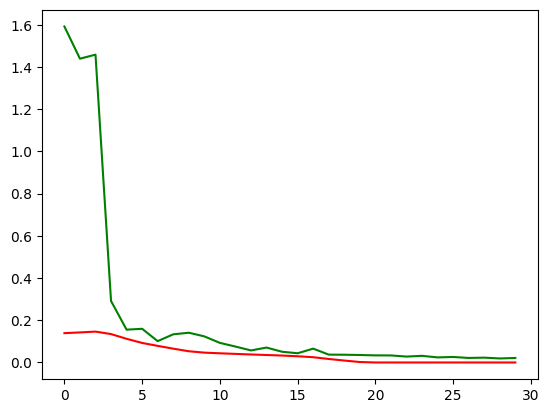

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_losses, 'g', valid_losses, 'r')